# EECS4404 Project 2

Jimmy Le<br>
216143992<br>
Prof. Archit Garg<br>
EECS4404 SU 2022

## References

Code Process and Method: EECS4404 Class Notes & Jupyter Examples<br>

Boxcox documentation provided by: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html

Reference for K-means cluster and elbow method: https://www.analyticsvidhya.com/blog/2021/01/in-depth-intuition-of-k-means-clustering-algorithm-in-machine-learning/

To Demonstrate full understanding of the code, full documentation and explaination of the code will be provided.

#### We start by performing EDA on the dataset

First explore the features of the dataset. By inspection of the .csv file, we can see that 'Region' and 'Channel' appear to be categorical and all of other continous. However, let's take a closer look at the data to verify this assumption

In [1]:
#Import libraries to be used to analyze dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

#Read in dataset
wholesale = pd.read_csv('Wholesale customers data.csv')
wholesale.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [2]:
#Check the number of rows and columns in the wholesale dataset
wholesale.shape

(440, 8)

In [3]:
#We also check the datatypes stored in each column
wholesale.dtypes

Channel             int64
Region              int64
Fresh               int64
Milk                int64
Grocery             int64
Frozen              int64
Detergents_Paper    int64
Delicassen          int64
dtype: object

In [4]:
#See the distribution of variable Region
wholesale['Region'].value_counts()

3    316
1     77
2     47
Name: Region, dtype: int64

In [5]:
#See distribution of target variable Channel
wholesale['Channel'].value_counts()
#Note from the output 'Channel' is BINARY!

1    298
2    142
Name: Channel, dtype: int64

In [6]:
# We can additionally verify which variables are categorical and continous with the following
for col in wholesale.columns:
    print('{}: {} unique values'.format(col, wholesale[col].nunique()))

Channel: 2 unique values
Region: 3 unique values
Fresh: 433 unique values
Milk: 421 unique values
Grocery: 430 unique values
Frozen: 426 unique values
Detergents_Paper: 417 unique values
Delicassen: 403 unique values


Reiterating what we mentioned earlier, we can make a distinction between our categorical and continous variables. We verify channel and region appear to be categorical variables above (as numerical indicator values, as they can be either one of 2  or 3 distnct values respectively). The other features, 'Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents', and 'Delicassen' all appear to be continous as they are varied integer values, due to them having many unique values!

We can also see by inspection of the region values that there is an imbalance in the region class. However, we can decide how to deal with this variable later.

## Explore Continous Features

In [7]:
from scipy import stats

#Drop cateogorical feature region to analyze continous features
#Note: We DO NOT drop our target variable Channel, although it is categorical as well
cat_feat = ['Region']
wholesale.drop(cat_feat, axis=1, inplace=True)
wholesale.head()

,Channel,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,12669,9656,7561,214,2674,1338
1,2,7057,9810,9568,1762,3293,1776
2,2,6353,8808,7684,2405,3516,7844
3,1,13265,1196,4221,6404,507,1788
4,2,22615,5410,7198,3915,1777,5185


In [8]:
#We can observe the general distrubution of these features
wholesale.describe()

,Channel,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [9]:
#We can observe a few things:

#Observation: There appears no null values in any rows as the count across each feature is consistent, so fortunately no need to have to account for any null values throughout our process
#Observation: There appears to be a large max value of spending on 'Fresh'. This appears to be bloating the mean and the std. Will have to inspect this further later in our analysis
#Observation: Clients appear to be spending the least on Detergents and Delicassen, and most on Fresh products


In [10]:
#Correlation matrix may give us some hints as to the correlation of these variables
wholesale.corr()

,Channel,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Channel,1.000000,-0.169172,0.460720,0.608792,-0.202046,0.636026,0.056011
Fresh,-0.169172,1.000000,0.100510,-0.011854,0.345881,-0.101953,0.244690
Milk,0.460720,0.100510,1.000000,0.728335,0.123994,0.661816,0.406368
Grocery,0.608792,-0.011854,0.728335,1.000000,-0.040193,0.924641,0.205497
Frozen,-0.202046,0.345881,0.123994,-0.040193,1.000000,-0.131525,0.390947
Detergents_Paper,0.636026,-0.101953,0.661816,0.924641,-0.131525,1.000000,0.069291
Delicassen,0.056011,0.244690,0.406368,0.205497,0.390947,0.069291,1.000000


Observation: We observe see looking at the matrix that Grocery and Detergents_Paper have the strongest correlation to Channel, our target variable, around 0.6 correlation, which clues us in that they are likely the strongest factors which may be useful in predicting the Channel for our Wholesale model.<br>Additionally, Milk appears to be somewhat corelated (0.46) while the others appear to be weakly correlated (+-0.2 correlation or less)

In [11]:
#We can use groupby to get a better idea of how the continous variables relate to target variable, we can inspect the means in relation to the Channel
wholesale.groupby('Channel').mean()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Channel,,,,,,
1,13475.560403,3451.724832,3962.137584,3748.251678,790.560403,1415.956376
2,8904.323944,10716.500000,16322.852113,1652.612676,7269.507042,1753.436620


In [12]:
#From initial observations, it appears that:
#    Channel 2 appears to have higher spending in Milk, Grocery, and Detergents_Paper
#    Channel 1 appears to have slightly more spending in Fresh, and Frozen
#       However, the averages of 'Fresh' may appear closer than expected due to outlier value of 112151 spent in fresh 
#       (which is a member of channel 1 by inspection of the .csv file)

c:\Users\Jimmy\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


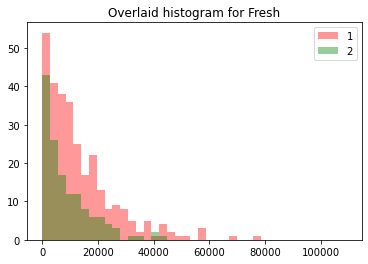

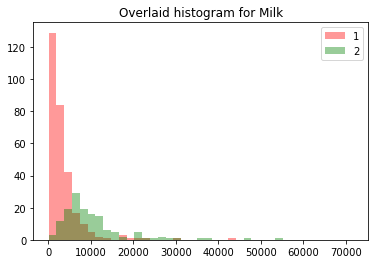

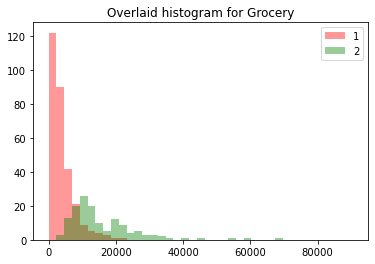

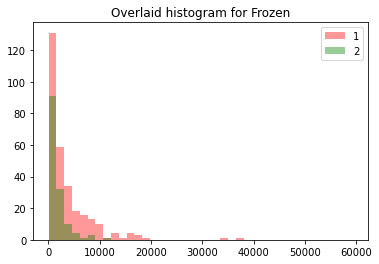

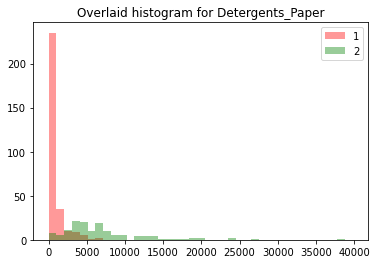

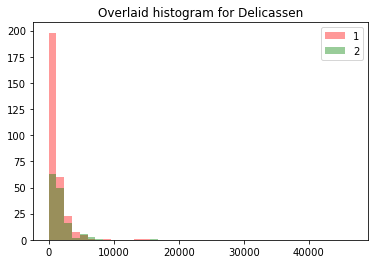

In [13]:
#We can get a visual representation below
for i in ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']: #For every feature
    c1 = list(wholesale[wholesale['Channel'] == 1][i].dropna()) #Drop null references
    c2 = list(wholesale[wholesale['Channel'] == 2][i].dropna())
    xmin = min(min(c1), min(c2)) #Dimensions of the plot
    xmax = max(max(c1), max(c2))
    width = (xmax - xmin) / 40
    #Draw the plots, arranging channel 1 as red and channel 2 as green
    sns.distplot(c1, color='r', kde=False, bins=np.arange(xmin, xmax, width)) 
    sns.distplot(c2, color='g', kde=False, bins=np.arange(xmin, xmax, width))
    plt.legend(['1', '2']) #Legends for plot
    plt.title('Overlaid histogram for {}'.format(i)) #Title
    plt.show()

In [14]:
#Observation: Channel 1 appears to have many clients who only spend relatively small amounts in each category
#    There are only a select few customers in each category who spend large amounts
#    Clients in channel 1 appear more likely to spend less
#    However, in channel 1 appear more likely to spend about modest to high amounts in Fresh 
#Observation: Customers in Clients of 2 have more spread out spending patterns, some more likely to spend more compared to their Channel 1 counterparts
#    In particular, clients in channel 2 are more likely to spend in Detergents_Paper, Grocery, Milk
#    On the flipside, customers of channel 1 are more likely to spend less in each category with the exception of Fresh (mentioned earlier)

## Explore Categorical Features

In [15]:
#Drop all continous features
#I.e., drop all features but 'Region' and 'Channel'
wholesale = pd.read_csv('Wholesale customers data.csv')
cont_feat = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
wholesale.drop(cont_feat, axis=1, inplace=True)
wholesale.head()

,Channel,Region
0,2,3
1,2,3
2,2,3
3,1,3
4,2,3


In [16]:
# Check if there are any missing values
wholesale.isnull().sum()

Channel    0
Region     0
dtype: int64

In [17]:
#We can observe here there are also no null values, so we do not need to worry about having to treat or look for any null values
#Additionally recall, from earlier, Region can be one of three values, (1,2,3)
#We can check the relationship with target with groupby
wholesale.groupby('Channel').mean()

,Region
Channel,
1,2.510067
2,2.612676


<Figure size 432x288 with 0 Axes>

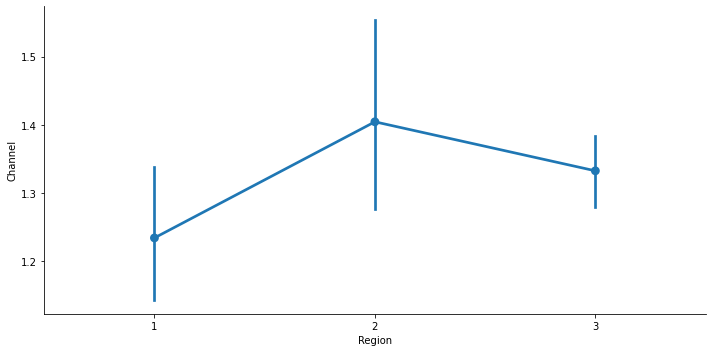

In [18]:
#From earlier, we also observed that the most of the Region values are 3
#   Which explains why the average value of region is close to 3 for both channels
#There appears to be no clear disinction if a channel favours a specific region from this
#We can plot the categorical features to find any pattern
for i, col in enumerate(['Region']): #Plot features
    plt.figure(i)
    sns.catplot(x=col, y='Channel', data=wholesale, kind='point', aspect=2, )

In [19]:
# Once again, region appears to have no significant impact on determining the channel

# Exploratory Data Analysis Conclusions

* Grocery and Detergents_Paper features are the strongest correlated features to target variable 'Channel', with a correlation of ~0.6
* Clients in channel 1 are more likely to spend less, with a select only few in channel 1 spending more
* Clients in channel 1 are more likely to spend modest to higher amounts in 'Fresh' products
* Clients in channel 2 have more spread out spending patterns, where clients in channel 2 are more likely to spend more than their channel 1 counterparts
* Channel 2 typically has higher spending in Milk, Grocery, and Detergents_Paper
* Clients in channel 1 appear more likely to spend more in Fresh
* Region appears to have no impact on the Channel

# Clean data

We read in our data again and begin clean using the lessons we learned from our exploratory data analysis

## Cap and Floor data to remove outliers

We remove outliers in our data so that it does not chase outliers and focuses on the actual trends of our data<br>

REASONING: We want to make sure our model follows the actual trends in the data and does not chase outliers. From inspection of the describe table we can see that for the continous features, the 'max' values of each feature are sometimes an order of magnitudes larger than the mean and many standard devitions away. Inspection of the csv file confirms that these values are much larger than the majority of these points. However, we should take a more thorough analysis to confirm.


In [20]:
#Read in data
wholesale = pd.read_csv('Wholesale customers data.csv')
wholesale.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [21]:
#We can check where outliers may be an issue in describe()
wholesale.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


From the above, we can see that the max values for the features, in particular, for Fresh, Milk, and Grocery seem extreme. Reiterating what we mentioned earlier, these values appear to be orders of magnitude larger and many standard deviations away from their mean. Let's check for outliers that are larger than a certain percentile of our data.

In [22]:
#Finds outliers higher than a certain percentile
def detect_outlier(feature):
    outliers = []
    data = wholesale[feature]
    mean = np.mean(data)
    std =np.std(data)
    
    #Loop through all values and count those who are larger than their given percentile/stds away
    for y in data:
        z_score= (y - mean)/std 
        if np.abs(z_score) > 3:
            outliers.append(y)
    print('\nOutlier caps for {}:'.format(feature))
    print('  --95p: {:.1f} / {} values exceed that'.format(data.quantile(.95),
                                                             len([i for i in data
                                                                  if i > data.quantile(.95)])))
    print('  --3sd: {:.1f} / {} values exceed that'.format(mean + 3*(std), len(outliers)))
    print('  --99p: {:.1f} / {} values exceed that'.format(data.quantile(.99),
                                                           len([i for i in data
                                                                if i > data.quantile(.99)])))

# Determine what the upperbound should be for our continuous features
for feat in ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']:
    detect_outlier(feat)


Outlier caps for Fresh:
  --95p: 36818.5 / 22 values exceed that
  --3sd: 49899.1 / 7 values exceed that
  --99p: 56082.6 / 5 values exceed that

Outlier caps for Milk:
  --95p: 16843.4 / 22 values exceed that
  --3sd: 27912.2 / 9 values exceed that
  --99p: 37610.1 / 5 values exceed that

Outlier caps for Grocery:
  --95p: 24033.5 / 22 values exceed that
  --3sd: 36428.4 / 7 values exceed that
  --99p: 43435.7 / 5 values exceed that

Outlier caps for Frozen:
  --95p: 9930.7 / 22 values exceed that
  --3sd: 17619.4 / 6 values exceed that
  --99p: 17964.8 / 5 values exceed that

Outlier caps for Detergents_Paper:
  --95p: 12043.2 / 22 values exceed that
  --3sd: 17168.8 / 10 values exceed that
  --99p: 22571.6 / 5 values exceed that

Outlier caps for Delicassen:
  --95p: 4485.4 / 22 values exceed that
  --3sd: 9975.6 / 4 values exceed that
  --99p: 8274.7 / 5 values exceed that


My goal of this outlier removal step is to remove the datapoints which are at the extremes. Out of 440 total data points, there are not too many extreme outliers. Additionally, the 99th percentile capped values given seem fairly aligned with this objective given:

* the shape of the data from the histogram we have completed above  
* the 25th to 75th percentile from the describe table 

As they do not deviate to the very high extremes from the outliers mentioned before. My goal here is to still represent that some portion of data represent clients who are really high spenders, without too much diminishing the fact they are high spenders, or outright omitting that from our data by using a smaller cap. Therefore, I choose to cap all continous features at the 99th percentile.

In [23]:
#Capping features
wholesale['Fresh_clean'] = wholesale['Fresh'].clip(upper=wholesale['Fresh'].quantile(.99))
wholesale['Milk_clean'] = wholesale['Milk'].clip(upper=wholesale['Milk'].quantile(.99))
wholesale['Grocery_clean'] = wholesale['Grocery'].clip(upper=wholesale['Grocery'].quantile(.99))
wholesale['Frozen_clean'] = wholesale['Frozen'].clip(upper=wholesale['Frozen'].quantile(.99))
wholesale['Detergents_Paper_clean'] = wholesale['Detergents_Paper'].clip(upper=wholesale['Detergents_Paper'].quantile(.99))
wholesale['Delicassen_clean'] = wholesale['Delicassen'].clip(upper=wholesale['Delicassen'].quantile(.99))

#Verify capping was successful by describing the data
wholesale.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Fresh_clean,Milk_clean,Grocery_clean,Frozen_clean,Detergents_Paper_clean,Delicassen_clean
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455,11797.643295,5641.214318,7715.149318,2891.643409,2787.916023,1387.448409
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937,11556.065072,6382.145852,8103.786401,3537.152169,4203.651451,1470.885271
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000,56082.610000,37610.060000,43435.740000,17964.820000,22571.610000,8274.660000


## Transform Skewed Features

We transform skewed features because we do not want our model to chase the long tail of our data instead of focusing on where the bulk of our data really is.<br>

REASONING: From observation of the histograms above (and soon below), our continous features feature long tails. The removal of our outliers may shorted some of these tails, but we expect that our outlier capping has only changed the tail so much. We can transform our data such that it makes it easier for our model to use. By doing so, it pulls our tail into a more compact distrubution, so our model does not get distracted chasing this tail!

In [24]:
# Read in data

import matplotlib.pyplot as plt
import scipy.stats
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import boxcox
import seaborn as sns
%matplotlib inline

wholesale.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Fresh_clean,Milk_clean,Grocery_clean,Frozen_clean,Detergents_Paper_clean,Delicassen_clean
0,2,3,12669,9656,7561,214,2674,1338,12669.0,9656.0,7561.0,214.0,2674.0,1338.0
1,2,3,7057,9810,9568,1762,3293,1776,7057.0,9810.0,9568.0,1762.0,3293.0,1776.0
2,2,3,6353,8808,7684,2405,3516,7844,6353.0,8808.0,7684.0,2405.0,3516.0,7844.0
3,1,3,13265,1196,4221,6404,507,1788,13265.0,1196.0,4221.0,6404.0,507.0,1788.0
4,2,3,22615,5410,7198,3915,1777,5185,22615.0,5410.0,7198.0,3915.0,1777.0,5185.0


array([[<AxesSubplot:title={'center':'Channel'}>,
        <AxesSubplot:title={'center':'Region'}>,
        <AxesSubplot:title={'center':'Fresh'}>,
        <AxesSubplot:title={'center':'Milk'}>],
       [<AxesSubplot:title={'center':'Grocery'}>,
        <AxesSubplot:title={'center':'Frozen'}>,
        <AxesSubplot:title={'center':'Detergents_Paper'}>,
        <AxesSubplot:title={'center':'Delicassen'}>],
       [<AxesSubplot:title={'center':'Fresh_clean'}>,
        <AxesSubplot:title={'center':'Milk_clean'}>,
        <AxesSubplot:title={'center':'Grocery_clean'}>,
        <AxesSubplot:title={'center':'Frozen_clean'}>],
       [<AxesSubplot:title={'center':'Detergents_Paper_clean'}>,
        <AxesSubplot:title={'center':'Delicassen_clean'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

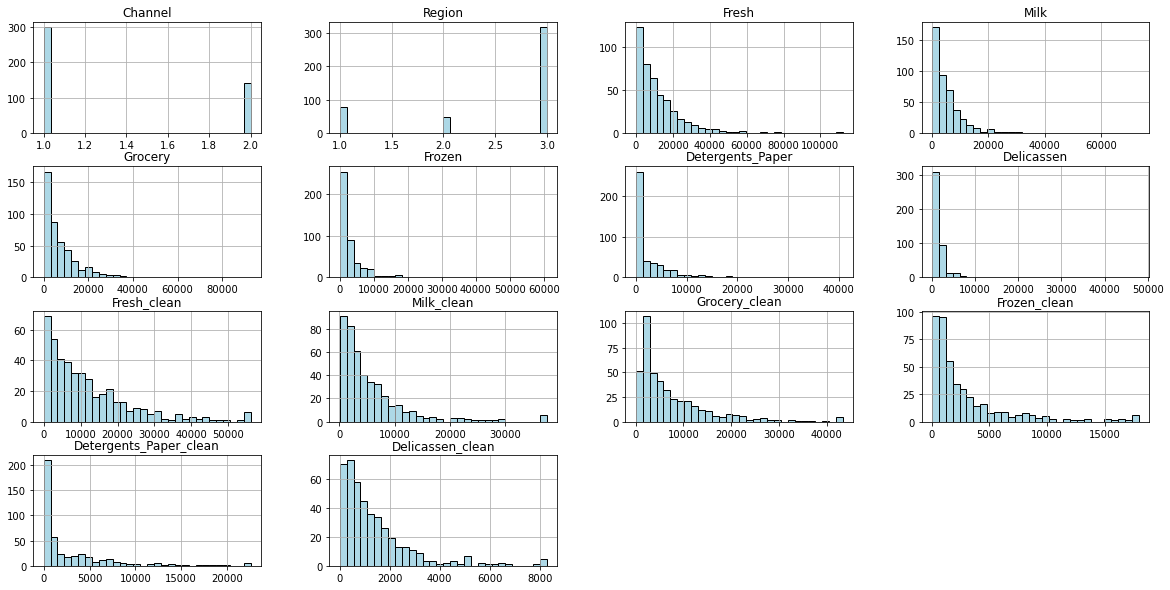

In [25]:
# Plot histogram for each continuous feature to see if a transformation is necessary
# We need to see if our continous features are skewed
# for feature in ['Fresh_clean', 'Milk_clean', 'Grocery_clean', 'Frozen_clean', 'Detergents_Paper_clean', 'Delicassen_clean']:
#     sns.distplot(wholesale[feature], kde=False)
#     plt.title('Histogram for {}'.format(feature))
#     plt.show()
wholesale.hist(figsize=(20,10),bins=30, color='lightblue', edgecolor='black')


We can see from the above that for our continous features, they still have long tails despite us dealing with the extreme outliers above. We can apply a Box-Cox power transformation to do so.

Boxcox documentation provided by: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html

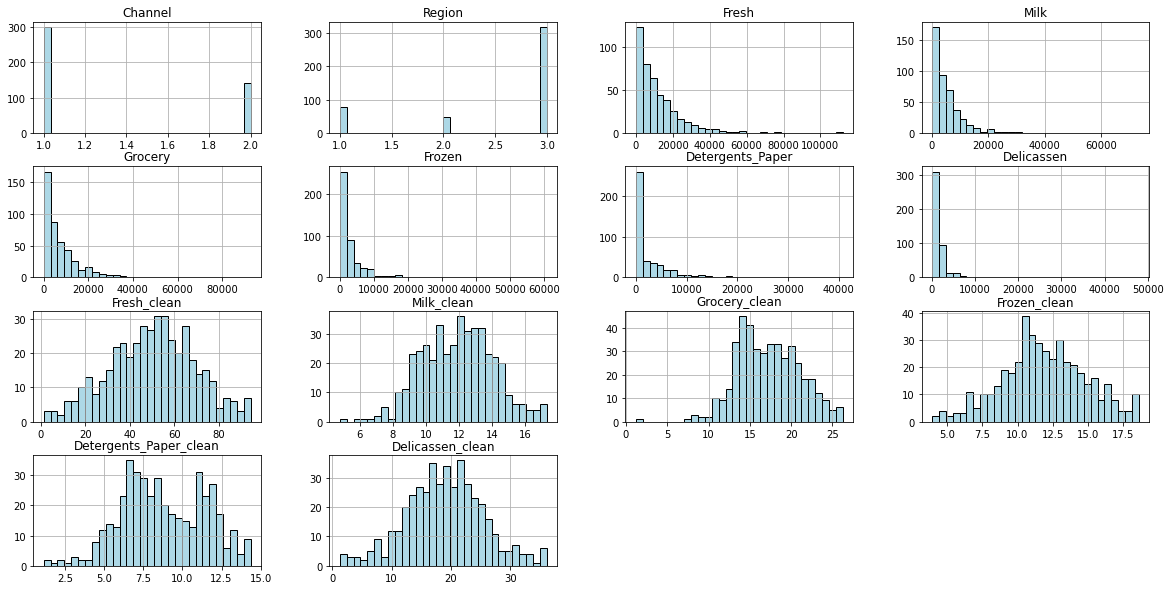

In [26]:
#Apply boxcox transformation from the scipy library
for i in wholesale.columns[8:]:
    #Add generic variables maxlog and ci as boxcox returns 3 args
    #See above for documentation
    wholesale[i], maxlog, ci=boxcox(wholesale[i]+0.0000001, alpha=0.05)
                                                                

wholesale.hist(figsize=(20,10),bins=30, color='lightblue', edgecolor='black')
plt.show()
# for feature in ['Fresh_clean', 'Milk_clean', 'Grocery_clean', 'Frozen_clean', 'Detergents_Paper_clean', 'Delicassen_clean']:
#     sns.distplot(wholesale[feature], kde=False)
#     plt.title('Histogram for {}'.format(feature))
#     plt.show()

In [27]:
#We can see that with the boxcox transformation, the distribution becomes a much more compact and normal form, more reasonable than our raw data
#Here, we do not need to worry about our model tryin to chase down values in a very long tail

# Export Cleaned data

In [28]:
#Note: We drop region from this data as it does not contribute to finding the channel
cleaned_features = ['Channel', 'Fresh_clean', 'Milk_clean', 'Grocery_clean', 'Frozen_clean', 'Detergents_Paper_clean', 'Delicassen_clean']
wholesale[cleaned_features].to_csv('wholesale_cleaned.csv', index=False)

# Implement Feature Scaling

In [29]:
# Import libraries
import warnings
warnings.simplefilter("ignore")

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split

%matplotlib inline

#Read in cleaned dataset from above
wholesale = pd.read_csv('wholesale_cleaned.csv')
wholesale.head()


,Channel,Fresh_clean,Milk_clean,Grocery_clean,Frozen_clean,Detergents_Paper_clean,Delicassen_clean
0,2,58.001424,14.074260,18.698869,7.522765,10.441302,21.088988
1,2,47.778956,14.109580,19.606780,12.076966,10.799759,22.990080
2,2,46.132787,13.870040,18.760089,12.851569,10.913613,35.607137
3,1,58.886503,9.815965,16.583318,15.487003,7.753625,23.037008
4,2,70.143370,12.814152,18.513120,14.124214,9.752385,31.589555


In [30]:
pd.DataFrame(wholesale).describe()

,Channel,Fresh_clean,Milk_clean,Grocery_clean,Frozen_clean,Detergents_Paper_clean,Delicassen_clean
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,50.057556,11.922646,17.206343,11.871224,8.772550,18.912966
std,0.468052,19.152988,2.169003,3.782760,2.990496,2.695459,6.571401
min,1.000000,1.310631,4.799154,1.193755,3.925965,1.140650,1.271119
25%,1.000000,36.337987,10.282324,14.358394,10.069701,6.738447,14.478820
50%,1.000000,50.836890,11.980938,17.001187,11.728505,8.493041,19.064879
75%,2.000000,63.806759,13.424943,20.032777,13.865790,11.104595,23.161979
max,2.000000,94.198720,17.294948,26.267546,18.617415,14.364994,36.158002


<AxesSubplot:ylabel='Density'>

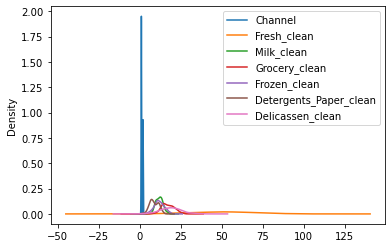

In [31]:
pd.DataFrame(wholesale).plot(kind='kde')

<AxesSubplot:ylabel='Frequency'>

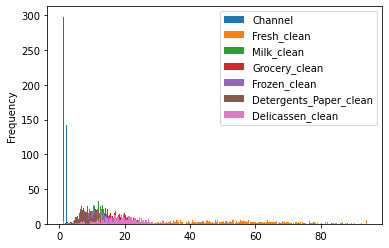

In [32]:
pd.DataFrame(wholesale).plot(kind='hist', bins=300)

In [33]:
#Observations:
#    We can see that the data is quite spread out in it's current form (which is more evidently seen in the histogram than the KDE)
#    We can use scaling to regularize our data

## Standard Scaler

In [34]:
#Start with standard scaler
from sklearn.preprocessing import StandardScaler
scaled1 = StandardScaler().fit_transform(wholesale)
scaled1 = pd.DataFrame(scaled1, columns=wholesale.columns)

scaled1[:5] #Output the first 5 rows

,Channel,Fresh_clean,Milk_clean,Grocery_clean,Frozen_clean,Detergents_Paper_clean,Delicassen_clean
0,1.448652,0.415231,0.993112,0.395009,-1.455748,0.619802,0.331512
1,1.448652,-0.119104,1.009414,0.635295,0.068877,0.752939,0.621139
2,1.448652,-0.205150,0.898851,0.411212,0.328194,0.795227,2.543320
3,-0.690297,0.461494,-0.972372,-0.164889,1.210467,-0.378446,0.628289
4,1.448652,1.049898,0.411489,0.345849,0.754241,0.363927,1.931250


In [35]:
pd.DataFrame(scaled1).describe() #We can see that standard scaling has made the std equivalent

,Channel,Fresh_clean,Milk_clean,Grocery_clean,Frozen_clean,Detergents_Paper_clean,Delicassen_clean
count,4.400000e+02,4.400000e+02,4.400000e+02,4.400000e+02,4.400000e+02,4.400000e+02,4.400000e+02
mean,-2.452584e-16,1.607300e-16,-4.299591e-16,5.462802e-16,-1.231338e-16,1.998401e-16,8.397323e-16
std,1.001138e+00,1.001138e+00,1.001138e+00,1.001138e+00,1.001138e+00,1.001138e+00,1.001138e+00
min,-6.902971e-01,-2.548031e+00,-3.287962e+00,-4.237862e+00,-2.659861e+00,-2.834615e+00,-2.687696e+00
25%,-6.902971e-01,-7.171302e-01,-7.571171e-01,-7.537329e-01,-6.031018e-01,-7.554997e-01,-6.755323e-01
50%,-6.902971e-01,4.073627e-02,2.690541e-02,-5.429621e-02,-4.777820e-02,-1.038145e-01,2.314355e-02
75%,1.448652e+00,7.186792e-01,6.934093e-01,7.480390e-01,6.677277e-01,8.661605e-01,6.473276e-01
max,1.448652e+00,2.307285e+00,2.479672e+00,2.398121e+00,2.258445e+00,2.077127e+00,2.627243e+00


<AxesSubplot:ylabel='Density'>

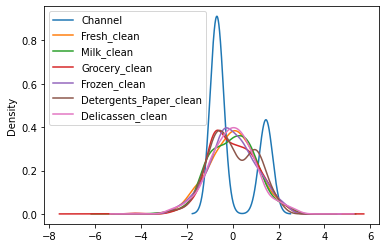

In [36]:
pd.DataFrame(scaled1).plot(kind='kde')


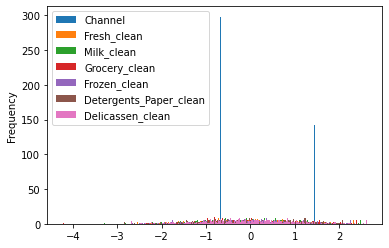

In [37]:
pd.DataFrame(scaled1).plot(kind='hist', bins=300);

### MinMaxScaler

In [38]:
wholesale = pd.read_csv('wholesale_cleaned.csv')
wholesale.head()

,Channel,Fresh_clean,Milk_clean,Grocery_clean,Frozen_clean,Detergents_Paper_clean,Delicassen_clean
0,2,58.001424,14.074260,18.698869,7.522765,10.441302,21.088988
1,2,47.778956,14.109580,19.606780,12.076966,10.799759,22.990080
2,2,46.132787,13.870040,18.760089,12.851569,10.913613,35.607137
3,1,58.886503,9.815965,16.583318,15.487003,7.753625,23.037008
4,2,70.143370,12.814152,18.513120,14.124214,9.752385,31.589555


In [39]:
from sklearn.preprocessing import MinMaxScaler

scaled3 = MinMaxScaler().fit_transform(wholesale)
scaled3 = pd.DataFrame(scaled3, columns=wholesale.columns)

scaled3[:5]

,Channel,Fresh_clean,Milk_clean,Grocery_clean,Frozen_clean,Detergents_Paper_clean,Delicassen_clean
0,1.0,0.610313,0.742258,0.698144,0.244823,0.703298,0.568061
1,1.0,0.500261,0.745085,0.734353,0.554813,0.730404,0.622554
2,1.0,0.482539,0.725915,0.700585,0.607537,0.739013,0.984210
3,0.0,0.619841,0.401480,0.613771,0.786923,0.500061,0.623899
4,1.0,0.741029,0.641416,0.690736,0.694162,0.651203,0.869050


In [40]:
pd.DataFrame(scaled3).describe() #Note that scaling has made the values between [0,1]

,Channel,Fresh_clean,Milk_clean,Grocery_clean,Frozen_clean,Detergents_Paper_clean,Delicassen_clean
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,0.322727,0.524792,0.570071,0.638619,0.540808,0.577110,0.505687
std,0.468052,0.206194,0.173579,0.150865,0.203553,0.203826,0.188363
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.377092,0.438801,0.525036,0.418184,0.423295,0.378586
50%,0.000000,0.533182,0.574736,0.630436,0.531094,0.555974,0.510042
75%,1.000000,0.672811,0.690295,0.751343,0.676572,0.753455,0.627481
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


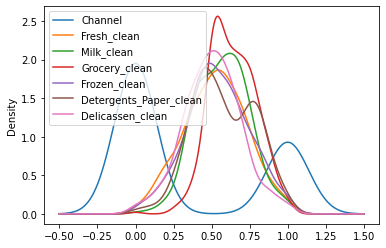

In [41]:
pd.DataFrame(scaled3).plot(kind='kde');

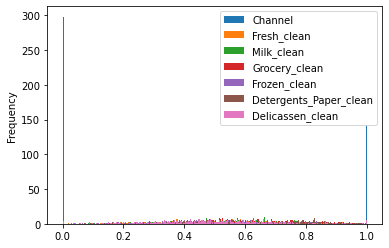

In [42]:
pd.DataFrame(scaled3).plot(kind='hist', bins=300);

In [43]:
#Moving foward, we choose to use the MinMaxScaler
#
#The graphs produced by both MinMax and Standard are almost identical (with the exception of the axies), most evidently shown in the KDE graphs as near identical curves
#Addtionally, having tested both the MinMax and Standard scalers on the remainder of the code, they both produce comparable results.
#We will choose to use the MinMax scaler, as it is cleaner to inspect data tables at a glance (no negatives, expected range of [0,1]) 
#  As well as the fact that the MinMax scaler already changes 'Channel' to a binary variable in convinient form 0,1 

In [44]:
scaled3.to_csv('wholesale_cleaned_scaled.csv', index=False) #Export results of scaling

# Find Optimal Number of Features using RFECV

In [45]:
wholesale = pd.read_csv('wholesale_cleaned_scaled.csv') #Read in data again
wholesale.head()

,Channel,Fresh_clean,Milk_clean,Grocery_clean,Frozen_clean,Detergents_Paper_clean,Delicassen_clean
0,1.0,0.610313,0.742258,0.698144,0.244823,0.703298,0.568061
1,1.0,0.500261,0.745085,0.734353,0.554813,0.730404,0.622554
2,1.0,0.482539,0.725915,0.700585,0.607537,0.739013,0.984210
3,0.0,0.619841,0.401480,0.613771,0.786923,0.500061,0.623899
4,1.0,0.741029,0.641416,0.690736,0.694162,0.651203,0.869050


In [46]:
#Set our data and targets equivalent to their respective columns
wholesale_data = wholesale[['Fresh_clean', 'Milk_clean', 'Grocery_clean', 'Frozen_clean', 'Detergents_Paper_clean', 'Delicassen_clean']]
wholesale_target = wholesale[['Channel']]

In [47]:
wholesale_data #Data

,Fresh_clean,Milk_clean,Grocery_clean,Frozen_clean,Detergents_Paper_clean,Delicassen_clean
0,0.610313,0.742258,0.698144,0.244823,0.703298,0.568061
1,0.500261,0.745085,0.734353,0.554813,0.730404,0.622554
2,0.482539,0.725915,0.700585,0.607537,0.739013,0.984210
3,0.619841,0.401480,0.613771,0.786923,0.500061,0.623899
4,0.741029,0.641416,0.690736,0.694162,0.651203,0.869050
...,...,...,...,...,...,...
435,0.811209,0.782197,0.818284,0.932516,0.385803,0.666875
436,0.889239,0.428369,0.404751,0.720274,0.315125,0.680161
437,0.639145,0.828370,0.930874,0.341181,0.938234,0.632592
438,0.568873,0.478205,0.529563,0.469516,0.377207,0.659206


In [48]:
##IF we use standard scaling, use this to change target to binary variable
# from sklearn import preprocessing
# from sklearn import utils

# #convert y values to categorical values
# lab = preprocessing.LabelEncoder()
# wholesale_target = lab.fit_transform(wholesale_target)

wholesale_target #Target variable

,Channel
0,1.0
1,1.0
2,1.0
3,0.0
4,1.0
...,...
435,0.0
436,0.0
437,1.0
438,0.0


In [49]:
#We are asked to find the optimal number of features with RFECV
#RFECV works by recursive feature elimination, that is, it arrives at the most important features of the model by eliminating the least important
#  and continuing this process until a requested number of features remain

#Import libraries including RFECV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, RFECV

#We apply random forest classifier and rank the features of relative importance (higher score usually is better)
rf = RandomForestClassifier(max_depth=7, random_state=1)
rfe = RFE(estimator=rf,n_features_to_select=6,step=1)
rfe.fit(wholesale_data, wholesale_target)

pd.Series(rfe.ranking_, index=['Fresh_clean', 'Milk_clean', 'Grocery_clean', 'Frozen_clean', 'Detergents_Paper_clean', 'Delicassen_clean']).sort_values(ascending=False)

Fresh_clean               1
Milk_clean                1
Grocery_clean             1
Frozen_clean              1
Detergents_Paper_clean    1
Delicassen_clean          1
dtype: int32

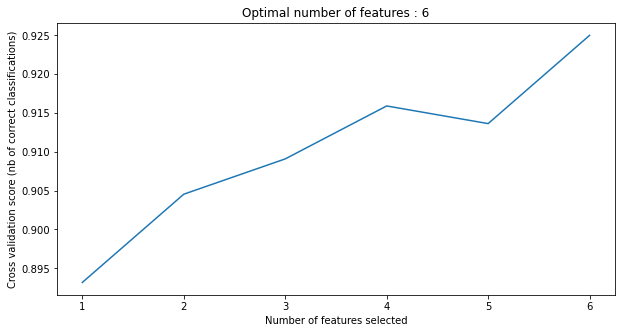

In [50]:
#From the results above, we can infer each of the features are of approximately equal importance, with each feature having an equivalent score of 1
#We can verify this further with RFECV to recursively elimate features and cross validate the model at each step
import matplotlib.pyplot as plt
rfecv = RFECV(estimator=rf)
rfecv.fit(wholesale_data, wholesale_target)

#Plot figure
plt.figure(figsize=(10,5))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.cv_results_['mean_test_score'])
plt.title("Optimal number of features : %d" % rfecv.n_features_)
plt.show()

Observations: All features appear to have been ranked of equal importance according to the scoring method. Additionally, the culmination of all 6 features appear to be relevant and important to predicting the target variable 'Channel' for our model.

## Implement K means clustering

For values K=2 and K=15 in addition to using elbow method to find values<br>
Reference for K-means cluster and elbow method: https://www.analyticsvidhya.com/blog/2021/01/in-depth-intuition-of-k-means-clustering-algorithm-in-machine-learning/

In [51]:
#Import libraries to perform this
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_validate

wholesale_data.head()

,Fresh_clean,Milk_clean,Grocery_clean,Frozen_clean,Detergents_Paper_clean,Delicassen_clean
0,0.610313,0.742258,0.698144,0.244823,0.703298,0.568061
1,0.500261,0.745085,0.734353,0.554813,0.730404,0.622554
2,0.482539,0.725915,0.700585,0.607537,0.739013,0.984210
3,0.619841,0.401480,0.613771,0.786923,0.500061,0.623899
4,0.741029,0.641416,0.690736,0.694162,0.651203,0.869050


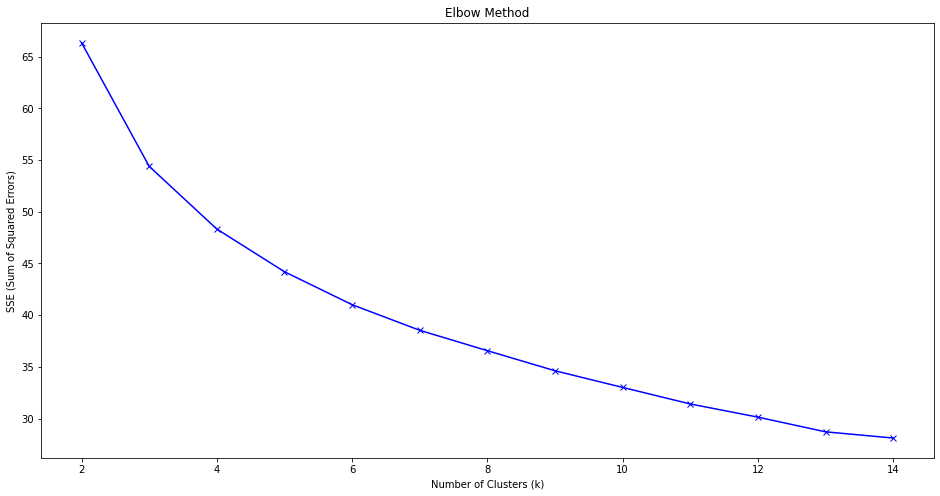

In [52]:
#We apply K means clustering over the range of K=2, and K=15
#Intertia attribute of kmeans represents the SSE, sum of squared errors, which we append to the SSE array to be plotted
SSE = []
for i in range(2,15):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=1)
    kmeans.fit(wholesale_data)
    SSE.append(kmeans.inertia_)

#Plot Elbow method graph
plt.figure(figsize=(16,8)) 
plt.plot(range(2,15), SSE, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('SSE (Sum of Squared Errors)')
plt.title('Elbow Method')
plt.show()


Recall, The goal of the elbow method is to find the K in which adding an addition marginally has any benifits. We can see at around K=5,6, the marginal benifit of an additional K begins to drop off, i.e., the point in which in which the line's distance between data points become close to constant, creating an "elbow" shape on the SSE vs K plot. 
<br>
We can predict using the elbow method that the optimum number of clusters is K=5,6

# Implement PCA

Find the variance from the first 2 componenets and the first 4 componenets

In [53]:
#For PCA, we will use our scaled wholesale dataset
wholesale_data

,Fresh_clean,Milk_clean,Grocery_clean,Frozen_clean,Detergents_Paper_clean,Delicassen_clean
0,0.610313,0.742258,0.698144,0.244823,0.703298,0.568061
1,0.500261,0.745085,0.734353,0.554813,0.730404,0.622554
2,0.482539,0.725915,0.700585,0.607537,0.739013,0.984210
3,0.619841,0.401480,0.613771,0.786923,0.500061,0.623899
4,0.741029,0.641416,0.690736,0.694162,0.651203,0.869050
...,...,...,...,...,...,...
435,0.811209,0.782197,0.818284,0.932516,0.385803,0.666875
436,0.889239,0.428369,0.404751,0.720274,0.315125,0.680161
437,0.639145,0.828370,0.930874,0.341181,0.938234,0.632592
438,0.568873,0.478205,0.529563,0.469516,0.377207,0.659206


In [54]:
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=1) #We apply Kmeans clustering with 5 components discovered by the elbow method
ymeans = kmeans.fit(wholesale_data) #We only apply PCA on CONTINOUS variables!!
wholesale_data.shape #Output the original shape of the data
#Output shows 440 rows, 6 columns, or a 6 dimensional space

(440, 6)

In [55]:
from sklearn.decomposition import PCA

p2 = PCA(n_components=2).fit(wholesale_data) #Perform PCA and reduce dimensions down to 2
pca2d = p2.transform(wholesale_data)

pca2d.shape #440 rows, and 2 columns

(440, 2)

In [56]:
p2.explained_variance_ratio_ #Output the variance ratio of our first 2 principle componenets

array([0.406548  , 0.30878174])

In [57]:
#From the output, we can see that the first principle component captures 40% of the variance, and the second principal component captures 30%, in total 70%
#As per the requirements, let's check the first 4 principle component

In [58]:
p4 = PCA(n_components=4).fit(wholesale_data) #Perform PCA and reduce dimensions down to 4
pca4d = p4.transform(wholesale_data)

pca4d.shape #440 rows, and 4 columns

(440, 4)

In [59]:
p4.explained_variance_ratio_

array([0.406548  , 0.30878174, 0.11723853, 0.10339001])

In [60]:
#From the output, we can see that the first and second capture 70%, with the other two capturing about 11 and 10% respectively
#Ideally, we want to pick our PCA component such that it captures approx. 70%-80% of the variance in our data
#Our first two principal componenets meet this criteria, and the first 4 approx. captures 90% of the variance in our dataset

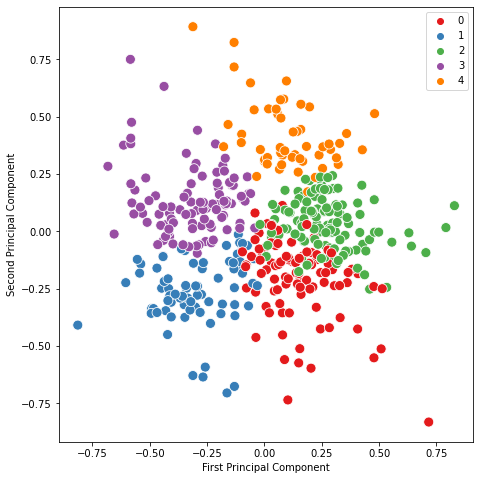

In [61]:
#Scatter plot of the first 2 dimensions with 5 clusters from elbow method
plt.figure(figsize = (8,8))
sns.scatterplot(pca4d[:,0], pca4d[:,1], 
                hue=ymeans.labels_, 
                palette='Set1',
                s=100)
plt.legend()
plt.gca().set_aspect("equal")
plt.ylabel('Second Principal Component')
plt.xlabel('First Principal Component')
plt.show()

Recap:
* From the output, we can see that the first and second capture 40% and 30% respectively, with the other two capturing about 11 and 10% respectively
* Ideally, we want to pick our PCA component such that it captures approx. 70%-80% of the variance in our data
* Our first two principal componenets meet this criteria, and the first 4 approx. captures 90% of the variance in our dataset

# Implement XGBoost

Output performance metrics for XGBoost (JUST cross_val_scores())<br>


In [62]:
from xgboost import XGBClassifier #Import XGBoostClassifier
from sklearn.model_selection import cross_val_score, KFold
#from sklearn.metrics import accuracy_score, precision_score, recall_score
features = wholesale_data #Set features to wholesale_data
features

,Fresh_clean,Milk_clean,Grocery_clean,Frozen_clean,Detergents_Paper_clean,Delicassen_clean
0,0.610313,0.742258,0.698144,0.244823,0.703298,0.568061
1,0.500261,0.745085,0.734353,0.554813,0.730404,0.622554
2,0.482539,0.725915,0.700585,0.607537,0.739013,0.984210
3,0.619841,0.401480,0.613771,0.786923,0.500061,0.623899
4,0.741029,0.641416,0.690736,0.694162,0.651203,0.869050
...,...,...,...,...,...,...
435,0.811209,0.782197,0.818284,0.932516,0.385803,0.666875
436,0.889239,0.428369,0.404751,0.720274,0.315125,0.680161
437,0.639145,0.828370,0.930874,0.341181,0.938234,0.632592
438,0.568873,0.478205,0.529563,0.469516,0.377207,0.659206


In [63]:
labels = wholesale_target #Set label to wholesale_target
labels

,Channel
0,1.0
1,1.0
2,1.0
3,0.0
4,1.0
...,...
435,0.0
436,0.0
437,1.0
438,0.0


In [64]:
#Perform 5 fold cross validation with XGBClassifier
xgbc = XGBClassifier()
scores = cross_val_score(xgbc, features, labels.values.ravel(), cv=5)
scores #We get a score of around 90%, which is fairly high!!

array([0.93181818, 0.89772727, 0.93181818, 0.93181818, 0.90909091])